In [15]:
import pandas as pd # it's about to RAM
import numpy as np
import matplotlib.pyplot as plt

n_turns=150

save res structure in file, as processing log files take time (30 minutes on group members' machin)

In [33]:
import pickle

# with open("view_res.pickle", "wb") as tf:
#     pickle.dump(view_res,tf, protocol=pickle.HIGHEST_PROTOCOL)
with open("subset_res.pickle", "rb") as tf:
    subset_res = pickle.load(tf)
with open("view_res.pickle", "rb") as tf:
    view_res = pickle.load(tf)     

Util function to summarize result for each particular setting

In [34]:
def process_one_iter(df, n_nodes, view_prop=0.15):
    discovery_df = df[df.Age>=0]

    discovery_rates = {}
    discovered_sets = [set() for i in range(n_nodes+1)]
    views = [[set() for turn in range(n_turns+1)]  for i in range(n_nodes+1)]
    for turn in range(n_turns+1):
        turn_df = df[df['Turn']==turn]
        discovery_rates[turn]=[]    
        for i in range(1,n_nodes+1):
            discovered = discovered_sets[i]
            view = views[i][turn]
            node_df = turn_df[turn_df['Id']==i]
            [(discovered.add(_),view.add(_)) for _ in node_df['Node']]
            discovery_rates[turn].append(len(discovered)/n_nodes)

    killed = int(df[df.Age==-1].Id)
    killed_occ = [[(1 if killed in views[node][turn] else 0) for node in range(n_nodes+1)]  for turn in range(n_turns+1)]
    last_turn = int(df[df.Age==-1].Turn)
    occ_rate = [np.mean(killed_occ[_])/view_prop for _ in range(last_turn, n_turns+1)]
    discovery_rates = [np.mean(discovery_rates[_]) for _ in range(n_turns+1)]
    return discovery_rates, occ_rate

def get_results_var_subset(n_nodes, subset_prop):
    global_discovery_rates = [0 for _ in range(n_turns+1)] 
    global_occ_rates = [0 for _ in range(n_turns+1)]
    
    for it in [1,2,3,4,5]:
        print(it)
        tmp_df = pd.read_csv(f'./measures-1/measures{n_nodes}-{subset_prop}/{it}.csv') 
        
        discovery_rates, occ_rates = process_one_iter(tmp_df, n_nodes)
        
        global_discovery_rates = [sum(t) for t in zip(discovery_rates, global_discovery_rates)]
        global_occ_rates = [sum(t) for t in zip(occ_rates, global_occ_rates)]
    
    global_discovery_rates = [rate/5 for rate in global_discovery_rates]
    global_occ_rates = [rate/5 for rate in global_occ_rates]

    return global_discovery_rates, global_occ_rates

def get_results_var_view(n_nodes, view_prop):
    global_discovery_rates = [0 for _ in range(n_turns+1)] 
    global_occ_rates = [0 for _ in range(n_turns+1)]
    
    for it in [1,2,3,4,5]:
        print(it)
        tmp_df = pd.read_csv(f'./measures-1/measures{n_nodes}-v{view_prop}/{it}.csv') 
        
        discovery_rates, occ_rates = process_one_iter(tmp_df, n_nodes, view_prop)
        
        global_discovery_rates = [sum(t) for t in zip(discovery_rates, global_discovery_rates)]
        global_occ_rates = [sum(t) for t in zip(occ_rates, global_occ_rates)]
    
    global_discovery_rates = [rate/5 for rate in global_discovery_rates]
    global_occ_rates = [rate/5 for rate in global_occ_rates]

    return global_discovery_rates, global_occ_rates



In [ ]:
# n_nodes = 100
# size_view = 0.1
# it=1
# tmp_df = pd.read_csv(f'./measures/measures{n_nodes}-{size_view}/log{it}.csv')         
# discovery_rates, occ_rates = process_one_iter(tmp_df, n_nodes, size_view)

Aggregate results before plots

In [29]:
# res = {}
# for n_nodes in [100,500,1000]:
#     res[n_nodes] = {} 
#     for subset_prop in [0.1, 0.075, 0.05]:
#         # 2 elements : 2 arrays (for each turn, give avg discovery rate 
#         #                                       and occ rate of exiting node)
#         res[n_nodes][size_view] = get_results_var_subset(n_nodes, subset_prop)
#res = {}
for n_nodes in [1000,500,1000]:
    #res[n_nodes] = {} 
    for view_prop in [0.1, 0.15, 0.20]:
        print(view_prop, n_nodes)
        # 2 elements : 2 arrays (for each turn, give avg discovery rate 
        #                                       and occ rate of exiting node)
        view_res[n_nodes][view_prop] = get_results_var_view(n_nodes, view_prop)
    for subset_prop in [0.05, 0.075, 0.1]:
        print(subset_prop, n_nodes)
        # 2 elements : 2 arrays (for each turn, give avg discovery rate 
        #                                       and occ rate of exiting node)
        subset_res[n_nodes][view_prop] = get_results_var_subset(n_nodes, view_prop)

0.1 1000
1
2
3
4
5
0.15 1000
1
2
3
4
5


Plot it, **discovery rate**

First, while varying the subset size

20
25
38


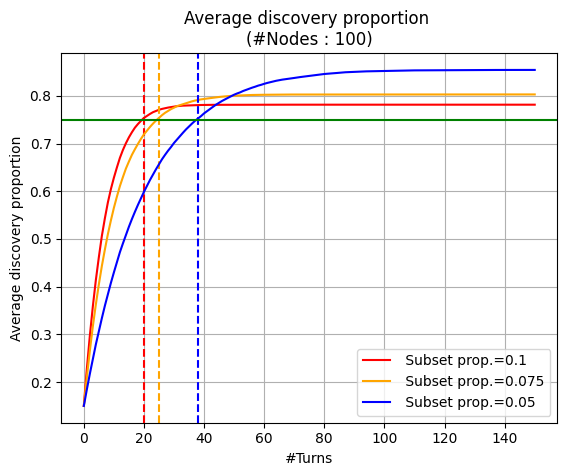

13
17
26


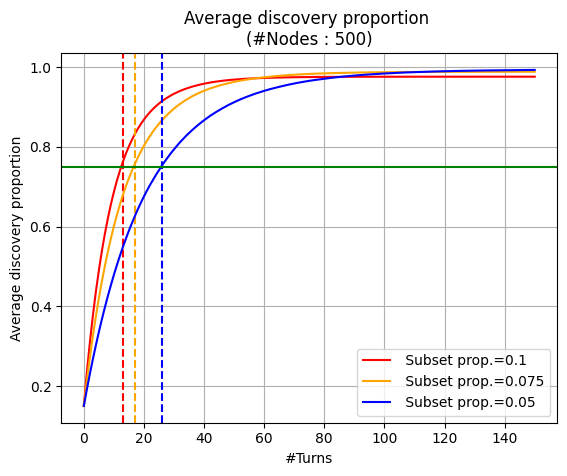

13
17
25


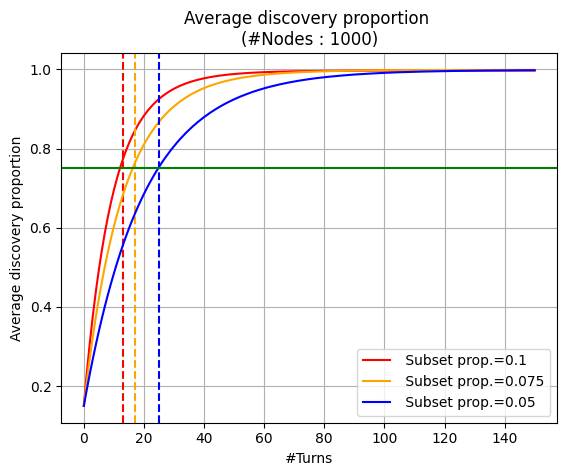

In [53]:
from matplotlib.text import Text

import bisect 
def find_ge(rates, th):
    i = bisect.bisect_left(rates, th)
    return i

for n_nodes in [100, 500,1000]:    
    th = 0.75

    turns = [_ for _ in range(n_turns+1)]
    discovery_rates = [subset_res[n_nodes][subset_prop][0] for subset_prop in [0.1,0.075,0.05]]

    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []
    for i, (rate, color) in enumerate([(0.1,'r'), (0.075,'orange'), (0.05, 'b')]):
        turn_th = find_ge(discovery_rates[i], th)
        plt.plot(turns, discovery_rates[i], color, label=' Subset prop.='+str(rate))
        #plt.errorbar(turns, discovery_rates[i], color=color, yerr=[0 for _ in turns], fmt="o", markersize=1.25, label=str(n_node)+' rate')
        if turn_th<n_turns+1:
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle='--')  
            
    

    plt.axhline(y=th, color='g', linestyle='-')  

    # Adding the title
    plt.title(f"Average discovery proportion \n(#Nodes : {n_nodes})")
    plt.legend()

    plt.grid(True)
    # Adding the labels
    plt.ylabel("Average discovery proportion")
    plt.xlabel("#Turns")
    plt.savefig(f'graphs1/discovery_{n_nodes}_subset.png')    
    plt.show()


vary the view size

38
31


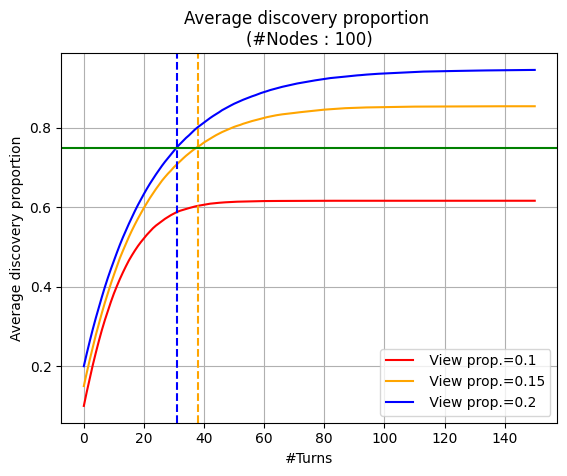

30
26
25


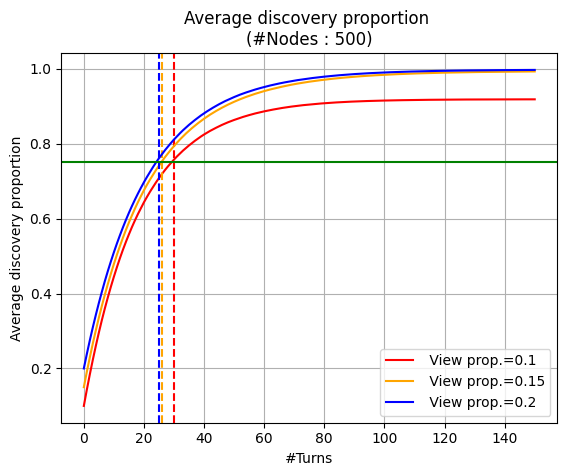

27
25
24


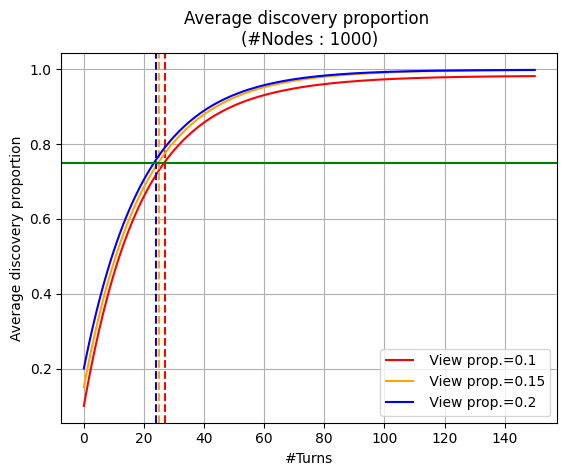

In [54]:
from matplotlib.text import Text

import bisect 
def find_ge(rates, th):
    i = bisect.bisect_left(rates, th)
    return i

for n_nodes in [100, 500,1000]:    
    th = 0.75

    turns = [_ for _ in range(n_turns+1)]
    discovery_rates = [view_res[n_nodes][view_prop][0] for view_prop in [0.1,0.15,0.2]]

    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []
    for i, (rate, color) in enumerate([(0.1,'r'), (0.15,'orange'), (0.2, 'b')]):
        turn_th = find_ge(discovery_rates[i], th)
        plt.plot(turns, discovery_rates[i], color, label=' View prop.='+str(rate))
        #plt.errorbar(turns, discovery_rates[i], color=color, yerr=[0 for _ in turns], fmt="o", markersize=1.25, label=str(n_node)+' rate')
        if turn_th<n_turns+1:
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle='--')  
            
    

    plt.axhline(y=th, color='g', linestyle='-')  

    # Adding the title
    plt.title(f"Average discovery proportion \n(#Nodes : {n_nodes})")
    plt.legend()

    plt.grid(True)
    # Adding the labels
    plt.ylabel("Average discovery proportion")
    plt.xlabel("#Turns")
    plt.savefig(f'graphs1/discovery_{n_nodes}_view.png')
    plt.show()


Let's then vary the cluster size

20
13
13


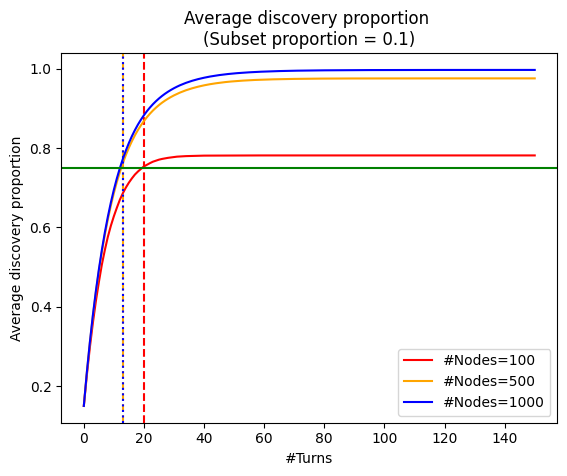

25
17
17


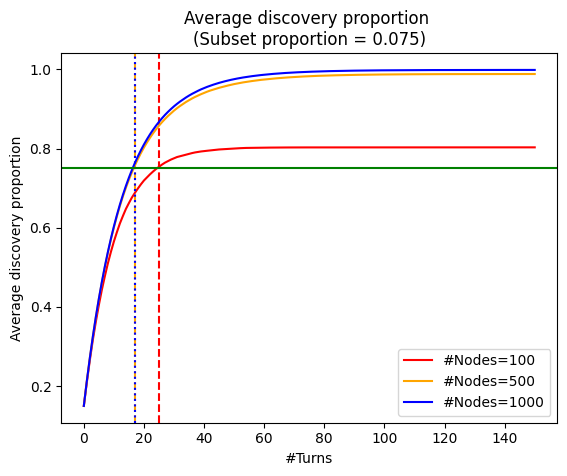

38
26
25


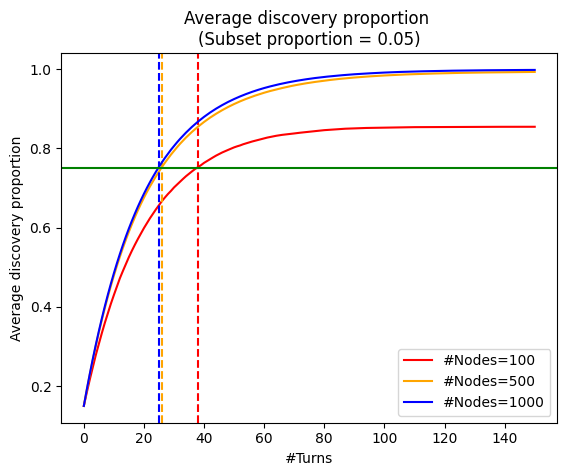

In [51]:
from matplotlib.text import Text

import bisect 
def find_ge(rates, th):
    i = bisect.bisect_left(rates, th)
    return i

for subset_prop in [0.1,0.075,0.05]:    
    th = 0.75

    turns = [_ for _ in range(n_turns+1)]
    discovery_rates = [subset_res[n_nodes][subset_prop][0] for n_nodes in [100, 500,1000]]
    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []

    for i, (n_node, color) in enumerate([(100,'r'), (500,'orange'), (1000, 'b')]):
        turn_th = find_ge(discovery_rates[i], th)
        plt.plot(turns, discovery_rates[i], color, label='#Nodes='+str(n_node))
#        plt.errorbar(turns, discovery_rates[i], color=color, yerr=[0 for _ in turns], fmt="o", markersize=1.25, label=str(n_node)+' nodes')

        if turn_th<n_turns+1:
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle=':' if turn_th in turn_ths else '--')  
            turn_ths.append(turn_th)
            
    

    plt.axhline(y=th, color='g', linestyle='-')  

    # Adding the title
    plt.title(f"Average discovery proportion \n(Subset proportion = {subset_prop})")
    plt.legend()
    # Adding the labels
    plt.ylabel("Average discovery proportion")
    plt.xlabel("#Turns")
    plt.savefig(f'graphs1/discovery_{subset_prop}.png')    
    plt.show()

plot it, resiliency against **exiting nodes**

vary the subset size

56
86
30


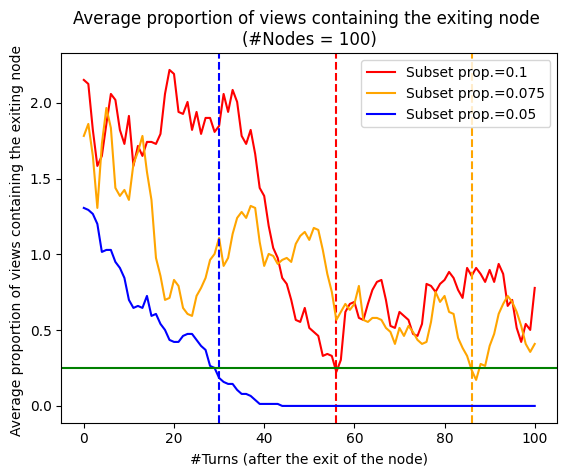

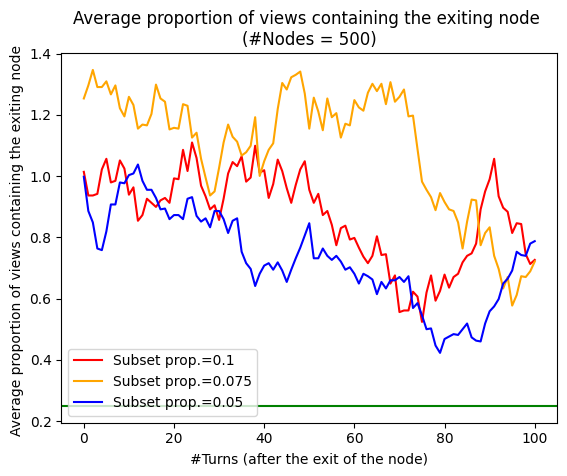

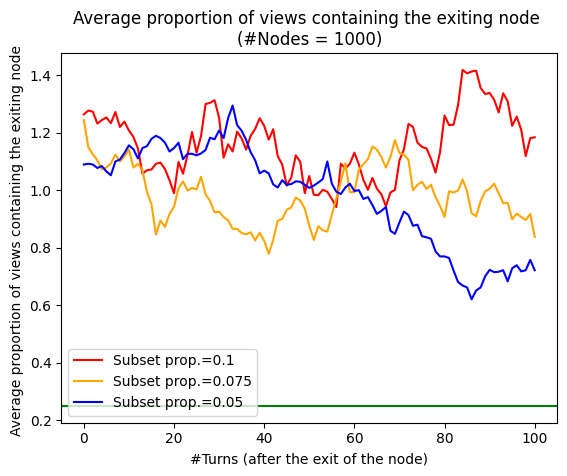

In [50]:
from matplotlib.text import Text

def find_le(rates, x):
    for i in range(len(rates)):
        if rates[i]<=x:
            return i
    return len(rates)+1

for n_nodes in [100, 500,1000]:    
    th = 0.25

    turns = [_ for _ in range(101)]
    exiting_rates = [subset_res[n_nodes][subset_prop][1][:101] for subset_prop in [0.1,0.075,0.05]]

    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []
    for i, (rate, color) in enumerate([(0.1,'r'), (0.075,'orange'), (0.05, 'b')]):
        turn_th = find_le(exiting_rates[i], th)
        plt.plot(turns, exiting_rates[i], color, label='Subset prop.='+str(rate))
        if turn_th<len(turns):
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle='--')  
            
    

    plt.axhline(y=th, color='green', linestyle='-')  

    # Adding the title
    plt.title(f"Average proportion of views containing the exiting node \n(#Nodes = {n_nodes})")
    plt.legend()
    # Adding the labels
    plt.ylabel("Average proportion of views containing the exiting node ")
    plt.xlabel("#Turns (after the exit of the node)")
    plt.savefig(f'graphs1/exiting_{n_nodes}_subset.png')    
    plt.show()


Vary the view size

0
30
29


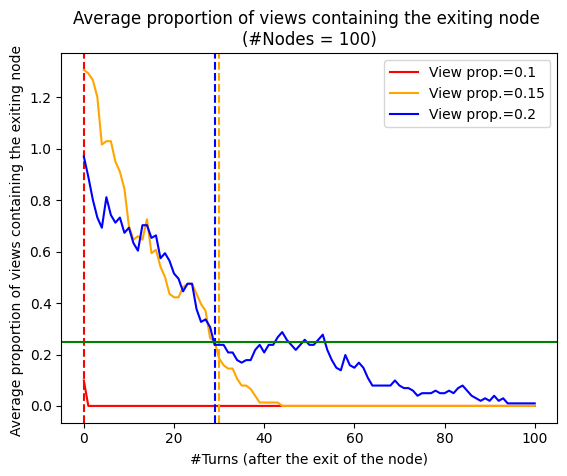

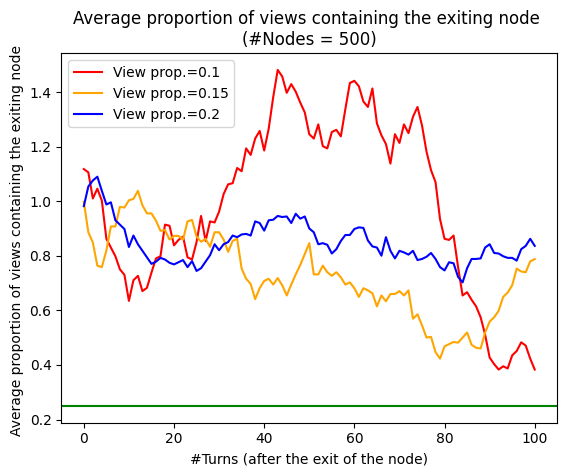

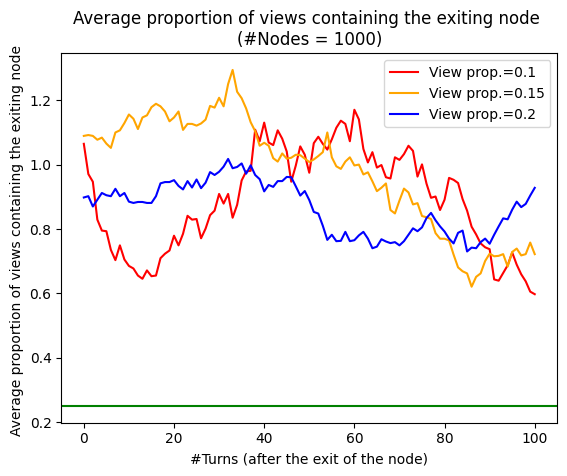

In [49]:
from matplotlib.text import Text

def find_le(rates, x):
    for i in range(len(rates)):
        if rates[i]<=x:
            return i
    return len(rates)+1

for n_nodes in [100, 500,1000]:    
    th = 0.25

    turns = [_ for _ in range(101)]
    exiting_rates = [view_res[n_nodes][view_prop][1][:101] for view_prop in [0.1,0.15,0.2]]

    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []
    for i, (rate, color) in enumerate([(0.1,'r'), (0.15,'orange'), (0.2, 'b')]):
        turn_th = find_le(exiting_rates[i], th)
        plt.plot(turns, exiting_rates[i], color, label='View prop.='+str(rate))
        if turn_th<len(turns):
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle='--')  
            
    

    plt.axhline(y=th, color='green', linestyle='-')  

    # Adding the title
    plt.title(f"Average proportion of views containing the exiting node \n(#Nodes = {n_nodes})")
    plt.legend()
    # Adding the labels
    plt.ylabel("Average proportion of views containing the exiting node ")
    plt.xlabel("#Turns (after the exit of the node)")
    plt.savefig(f'graphs1/exiting_{n_nodes}_view.png')    
    plt.show()


Vary the cluster size

30


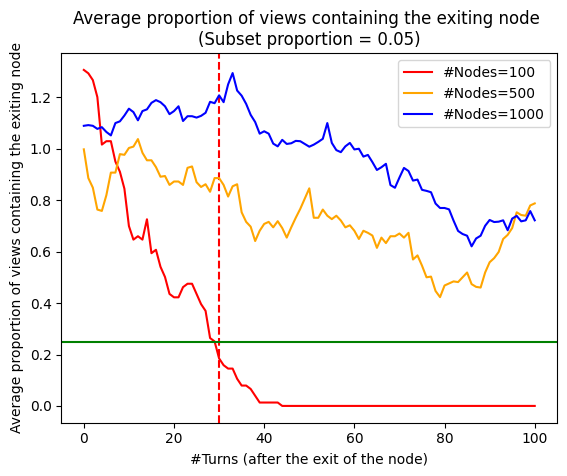

86


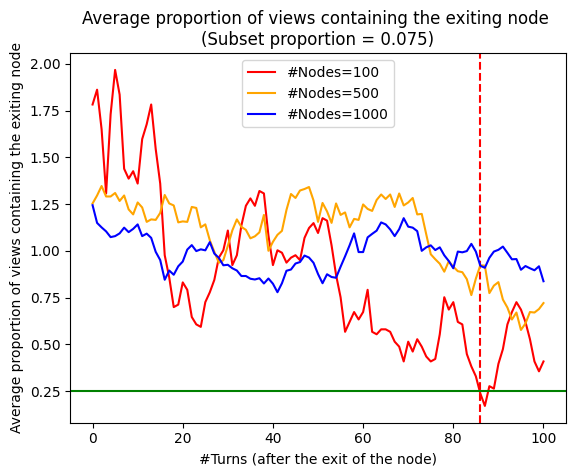

56


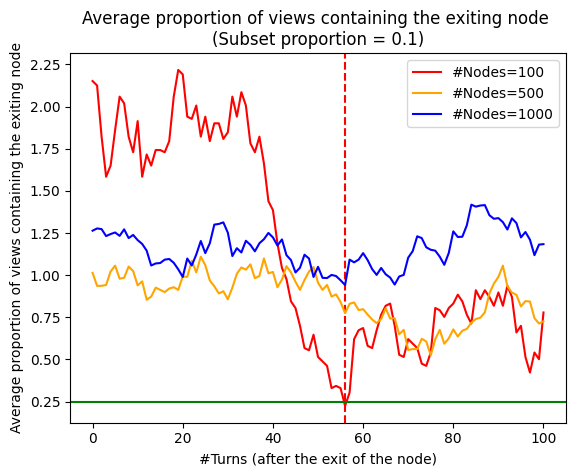

In [48]:
from matplotlib.text import Text

def find_le(rates, x):
    for i in range(len(rates)):
        if rates[i]<=x:
            return i
    return len(rates)+1

for subset_prop in [0.05,0.075,0.1]:    
    th = 0.25

    turns = [_ for _ in range(101)]
    occ_rates = [subset_res[n_nodes][subset_prop][1][:101] for n_nodes in [100, 500,1000]]

    
    # print(turn_th)
    turn_ths = []
    repre_ths = []
    colors_xticks = []
    for i, (n_node, color) in enumerate([(100,'r'), (500,'orange'), (1000, 'b')]):
        turn_th = find_le(occ_rates[i], th)
        plt.plot(turns, occ_rates[i], color, label='#Nodes='+str(n_node))
        if turn_th<len(turns):
            print(turn_th)
            plt.axvline(x=turn_th, color=color, linestyle='--')  
            
    

    plt.axhline(y=th, color='green', linestyle='-')  

    # Adding the title
    plt.title(f"Average proportion of views containing the exiting node \n(Subset proportion = {subset_prop})")
    plt.legend()
    # Adding the labels
    plt.ylabel("Average proportion of views containing the exiting node")
    plt.xlabel("#Turns (after the exit of the node)")
    plt.savefig(f'graphs1/exiting_{subset_prop}.png')        
    plt.show()